Nama : Bayu Abdurrosyid

Email : bayuuabdur2903@gmail.com


In [ ]:
from google.colab import files

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as py

import os
import shutil
import subprocess as sbp

In [ ]:
!pip install -q kaggle

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bayuabdurrosyid","key":"6c6509d7ab8892f296e1ff35889baee3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shiv28/animal-5-mammal

100% 890M/892M [00:33<00:00, 45.0MB/s]
100% 892M/892M [00:33<00:00, 27.7MB/s]


In [ ]:
!mkdir mammal
!unzip -qq animal-5-mammal.zip -d mammal

In [ ]:
dir = '/content/mammal/Animal/train'

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    fill_mode = 'nearest',
    horizontal_flip = True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.15,
    validation_split = 0.2
)

In [ ]:
w = 150
h = 150

train_dataset = datagen.flow_from_directory(
    dir,
    class_mode='categorical',
    subset = 'training',
    target_size = (w, h),
    batch_size = 256
)

validation_dataset = datagen.flow_from_directory(
    dir,
    class_mode='categorical',
    subset = 'validation',
    target_size = (w, h),
    batch_size = 256
)

Found 10799 images belonging to 5 classes.
Found 2697 images belonging to 5 classes.


In [ ]:

model = Sequential(
    [
     layers.Conv2D(64, (3,3), activation='relu', input_shape=(w, h, 3)),
     layers.MaxPooling2D(2, 2),
     layers.Conv2D(64, (3, 3), activation='relu'),
     layers.MaxPooling2D(2, 2),
     layers.Dropout(0.2),
     layers.Conv2D(128, (3, 3), activation='relu'),
     layers.MaxPooling2D(2, 2),
     layers.Dropout(0.5),
     layers.Conv2D(256, (3, 3), activation='relu'),
     layers.MaxPooling2D(2, 2),
     layers.Dropout(0.5),
     layers.Flatten(),
     layers.Dense(512, activation = 'relu'),
     layers.Dense(256, activation = 'relu'),
     layers.Dense(5, activation = 'softmax')
    ]
)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       7

In [ ]:
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epocj, logs = None):
    if (logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98):
      print('Akurasi telah mencapai 98%!')
      self.model.stop_training = True

In [ ]:
history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    validation_steps = 5,
    epochs = 150,
    verbose = 2,
    callbacks = [callback()]    
)

Epoch 1/150
43/43 - 119s - loss: 1.5753 - accuracy: 0.2734 - val_loss: 1.4783 - val_accuracy: 0.3609 - 119s/epoch - 3s/step
Epoch 2/150
43/43 - 100s - loss: 1.4470 - accuracy: 0.3832 - val_loss: 1.3899 - val_accuracy: 0.4305 - 100s/epoch - 2s/step
Epoch 3/150
43/43 - 100s - loss: 1.3384 - accuracy: 0.4522 - val_loss: 1.2865 - val_accuracy: 0.4703 - 100s/epoch - 2s/step
Epoch 4/150
43/43 - 99s - loss: 1.2003 - accuracy: 0.5182 - val_loss: 1.0805 - val_accuracy: 0.5750 - 99s/epoch - 2s/step
Epoch 5/150
43/43 - 99s - loss: 1.0383 - accuracy: 0.5858 - val_loss: 0.8948 - val_accuracy: 0.6531 - 99s/epoch - 2s/step
Epoch 6/150
43/43 - 100s - loss: 0.9414 - accuracy: 0.6274 - val_loss: 0.8192 - val_accuracy: 0.6805 - 100s/epoch - 2s/step
Epoch 7/150
43/43 - 98s - loss: 0.8416 - accuracy: 0.6706 - val_loss: 0.7513 - val_accuracy: 0.6883 - 98s/epoch - 2s/step
Epoch 8/150
43/43 - 98s - loss: 0.7917 - accuracy: 0.6846 - val_loss: 0.6666 - val_accuracy: 0.7312 - 98s/epoch - 2s/step
Epoch 9/150
43/4

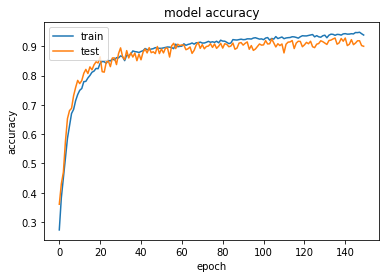

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

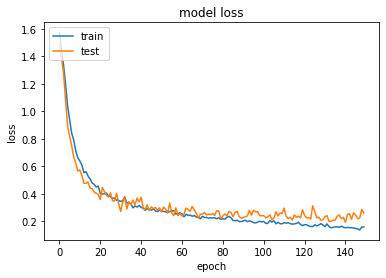

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
   f.write(tflite_model)